In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
from matplotlib import pyplot as plt, cm as mpl_cm
from cycler import cycler

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

/data1/maolp/mamba/envs/Pyscan/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata1=sc.read_h5ad('/home/maolp/data5/Gaofeng_All_matrix/Allcount/All_scanpyData/Data/Scanpy_merge_rmdoubulet_UMAP_label_lastCell.h5ad')

In [3]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()
%load_ext rpy2.ipython


In [4]:
path_data = "/data5/maolp/Gaofeng_All_matrix/Allcount/All_scanpyData/BCRTCR"
# path_bcr_input = f"{path_data}/Gao_All_BCR.csv"
path_tcr_input = f"{path_data}/Gao_All_TCR.csv"

In [5]:
# path_bcr_csv = f"{path_data}/BCR_read_aligned.csv"
# path_bcr_out = f"{path_data}/BCR_preprocessed.h5ad"

path_tcr_csv = f"{path_data}/TCR_read_aligned.csv"
path_tcr_out = f"{path_data}/TCR_preprocessed.h5ad"

In [6]:
adata_tcr = ir.io.read_10x_vdj(path_tcr_csv)
print(f"Amount cells: {len(adata_tcr)}")

/data1/maolp/mamba/envs/Pyscan/lib/python3.9/site-packages/scirpy/io/_convert_anndata.py:81: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(obs=ir_df, X=np.empty([ir_df.shape[0], 0]))


Amount cells: 78452


In [7]:
ir.pp.merge_with_ir(adata1, adata_tcr)

In [8]:
# ir.tl.chain_qc(adata_bcr2)
ir.tl.chain_qc(adata1)

In [9]:
adata=adata1[adata1.obs['chain_pairing'].isin(['single pair','extra VJ','extra VDJ'])]

In [10]:
ir.pp.ir_dist(adata, sequence="nt")

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.


/data1/maolp/mamba/envs/Pyscan/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [11]:
ir.tl.define_clonotypes(adata, receptor_arms="all", dual_ir="primary_only")

Initializing lookup tables. 
Computing clonotype x clonotype distances.
NB: Computation happens in chunks. The progressbar only advances when a chunk has finished. 


100%|█████████████████████████████████████████████████████████████████| 56947/56947 [01:58<00:00, 480.17it/s]


Stored clonal assignments in `adata.obs["clone_id"]`.


In [12]:
ir.tl.clonotype_network(adata, min_cells=2)

<Axes: >

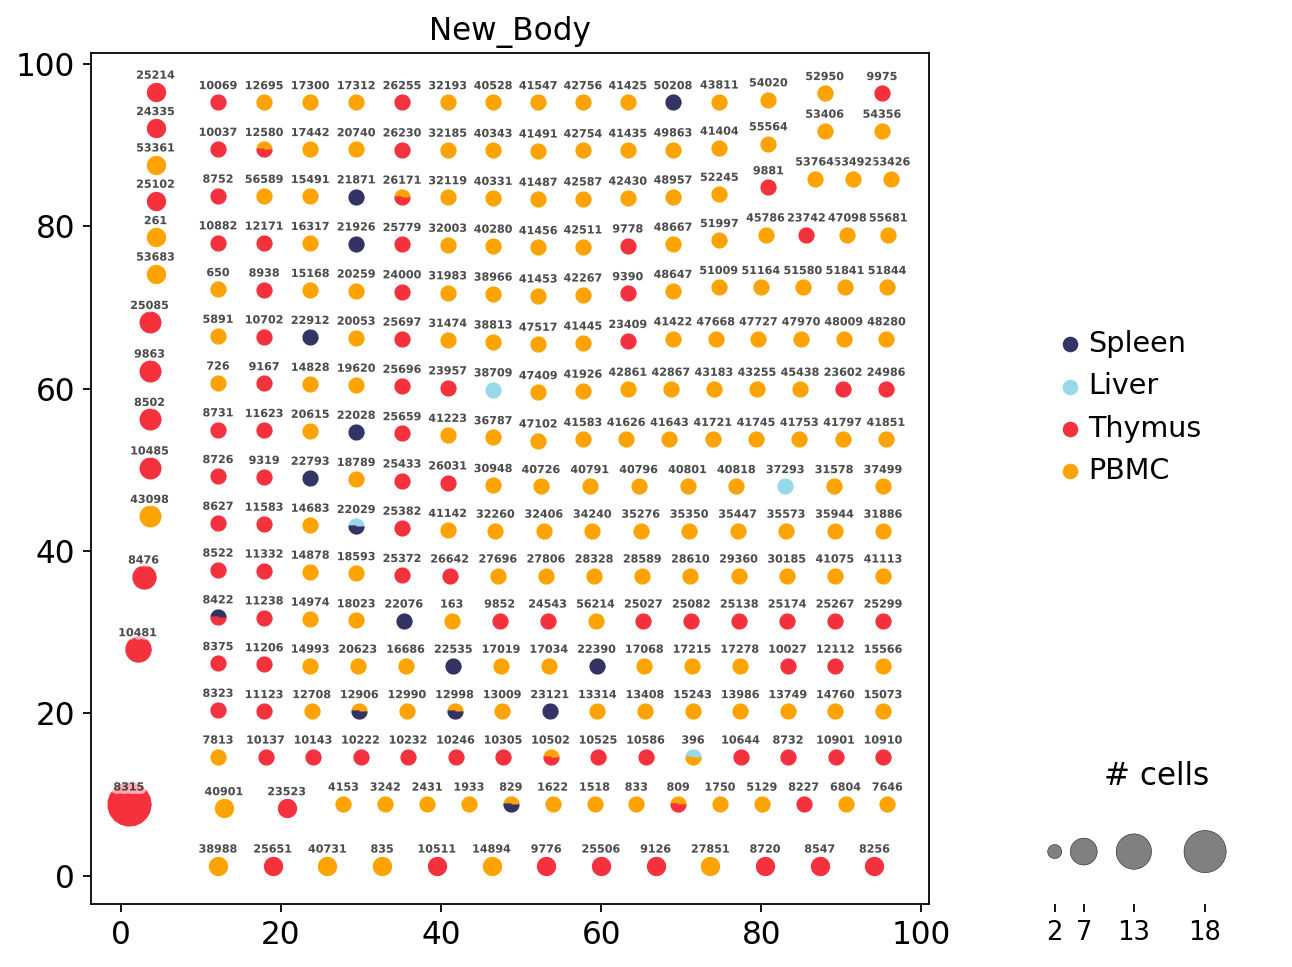

In [13]:
ir.pl.clonotype_network(
    adata, color="New_Body", base_size=20, label_fontsize=5, panel_size=(7, 7)
)

In [14]:
ir.tl.alpha_diversity(adata,groupby="AdjustedID",metric="simpson",fig_kws={"figsize": (10, 6)})
ir.tl.alpha_diversity(adata,groupby="AdjustedID",metric="chao1",fig_kws={"figsize": (10, 6)})

ir.tl.alpha_diversity(adata,groupby="AdjustedID",metric="normalized_shannon_entropy",fig_kws={"figsize": (10, 6)})

Alpha diversity saved to `obs['simpson_clone_id']
Alpha diversity saved to `obs['chao1_clone_id']
Alpha diversity saved to `obs['normalized_shannon_entropy_clone_id']


In [15]:

unique_data = adata.obs[['AdjustedID','Week','New_Body','simpson_clone_id','chao1_clone_id','normalized_shannon_entropy_clone_id']].drop_duplicates(subset='AdjustedID')

print(unique_data)

                        AdjustedID   Week New_Body simpson_clone_id  \
Cellname                                                              
Z48_AAAGCAACATGACGGA-1    B17.4_P3  19.43     PBMC         0.993631   
Z53_AAACCTGAGCAATATG-1   B23.4_P10  25.43     PBMC         0.999795   
Z96_AAACCTGAGAACTGTA-1   B39.1_P22  41.14     PBMC         0.999684   
D25_AAACCTGAGTACGATA-1    T18.6_P5  20.57   Thymus         0.999169   
D36_AAACCTGAGTGTCTCA-1   T10.1_P25  12.14   Thymus         0.999632   
Z99_AAACCTGAGGTTACCT-1    B18.6_P5  20.57     PBMC         0.999537   
Z38_AAACCTGAGTTGAGAT-1   B31.3_P15  33.29     PBMC         0.999319   
Z67_AAACCTGAGCCCGAAA-1    B18.0_P4  20.00     PBMC         0.999767   
Z07_AAACCTGCACGCTTTC-1   B26.9_P12  28.86     PBMC         0.999303   
B25_AAACCTGAGCACCGCT-1    S18.6_P5  20.57   Spleen         0.999340   
D9_AAACCTGAGCCGGTAA-1    T24.6_P11  26.57   Thymus         0.999368   
D27_AAACCTGCACATGACT-1    T10.0_P1  12.00   Thymus         0.999442   
Z52_AA

In [16]:
%%R -i unique_data
library(tidyverse)
unique_data<- unique_data %>% mutate(inverse_simpson_index = 1 / as.numeric(simpson_clone_id))
unique_data

/data1/maolp/mamba/envs/Pyscan/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "simpson_clone_id". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/data1/maolp/mamba/envs/Pyscan/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "chao1_clone_id". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
                        AdjustedID  Week New_Body   simpson_clone_id
Z48_AAAGCAACATGACGGA-1    B17.4_P3 19.43     PBMC 0.9936305732484076
Z53_AAACCTGAGCAATATG-1   B23.4_P10 25.43     PBMC 0.9997945022907122
Z96_AAACCTGAGAACTGTA-1   B39.1_P22 41.14     PBMC 0.9996837476087265
D25_AAACCTGAGTACGATA-1    T18.6_P5 20.57   Thymus 0.9991689062456258
D36_AAACCTGAGTGTCTCA-1   T10.1_P25 12.14   Thymus 0.9996324918887484
Z99_AAACCTGAGGTTACCT-1    B18.6_P5 20.57     PBMC 0.9995366330

`geom_smooth()` using formula = 'y ~ x'


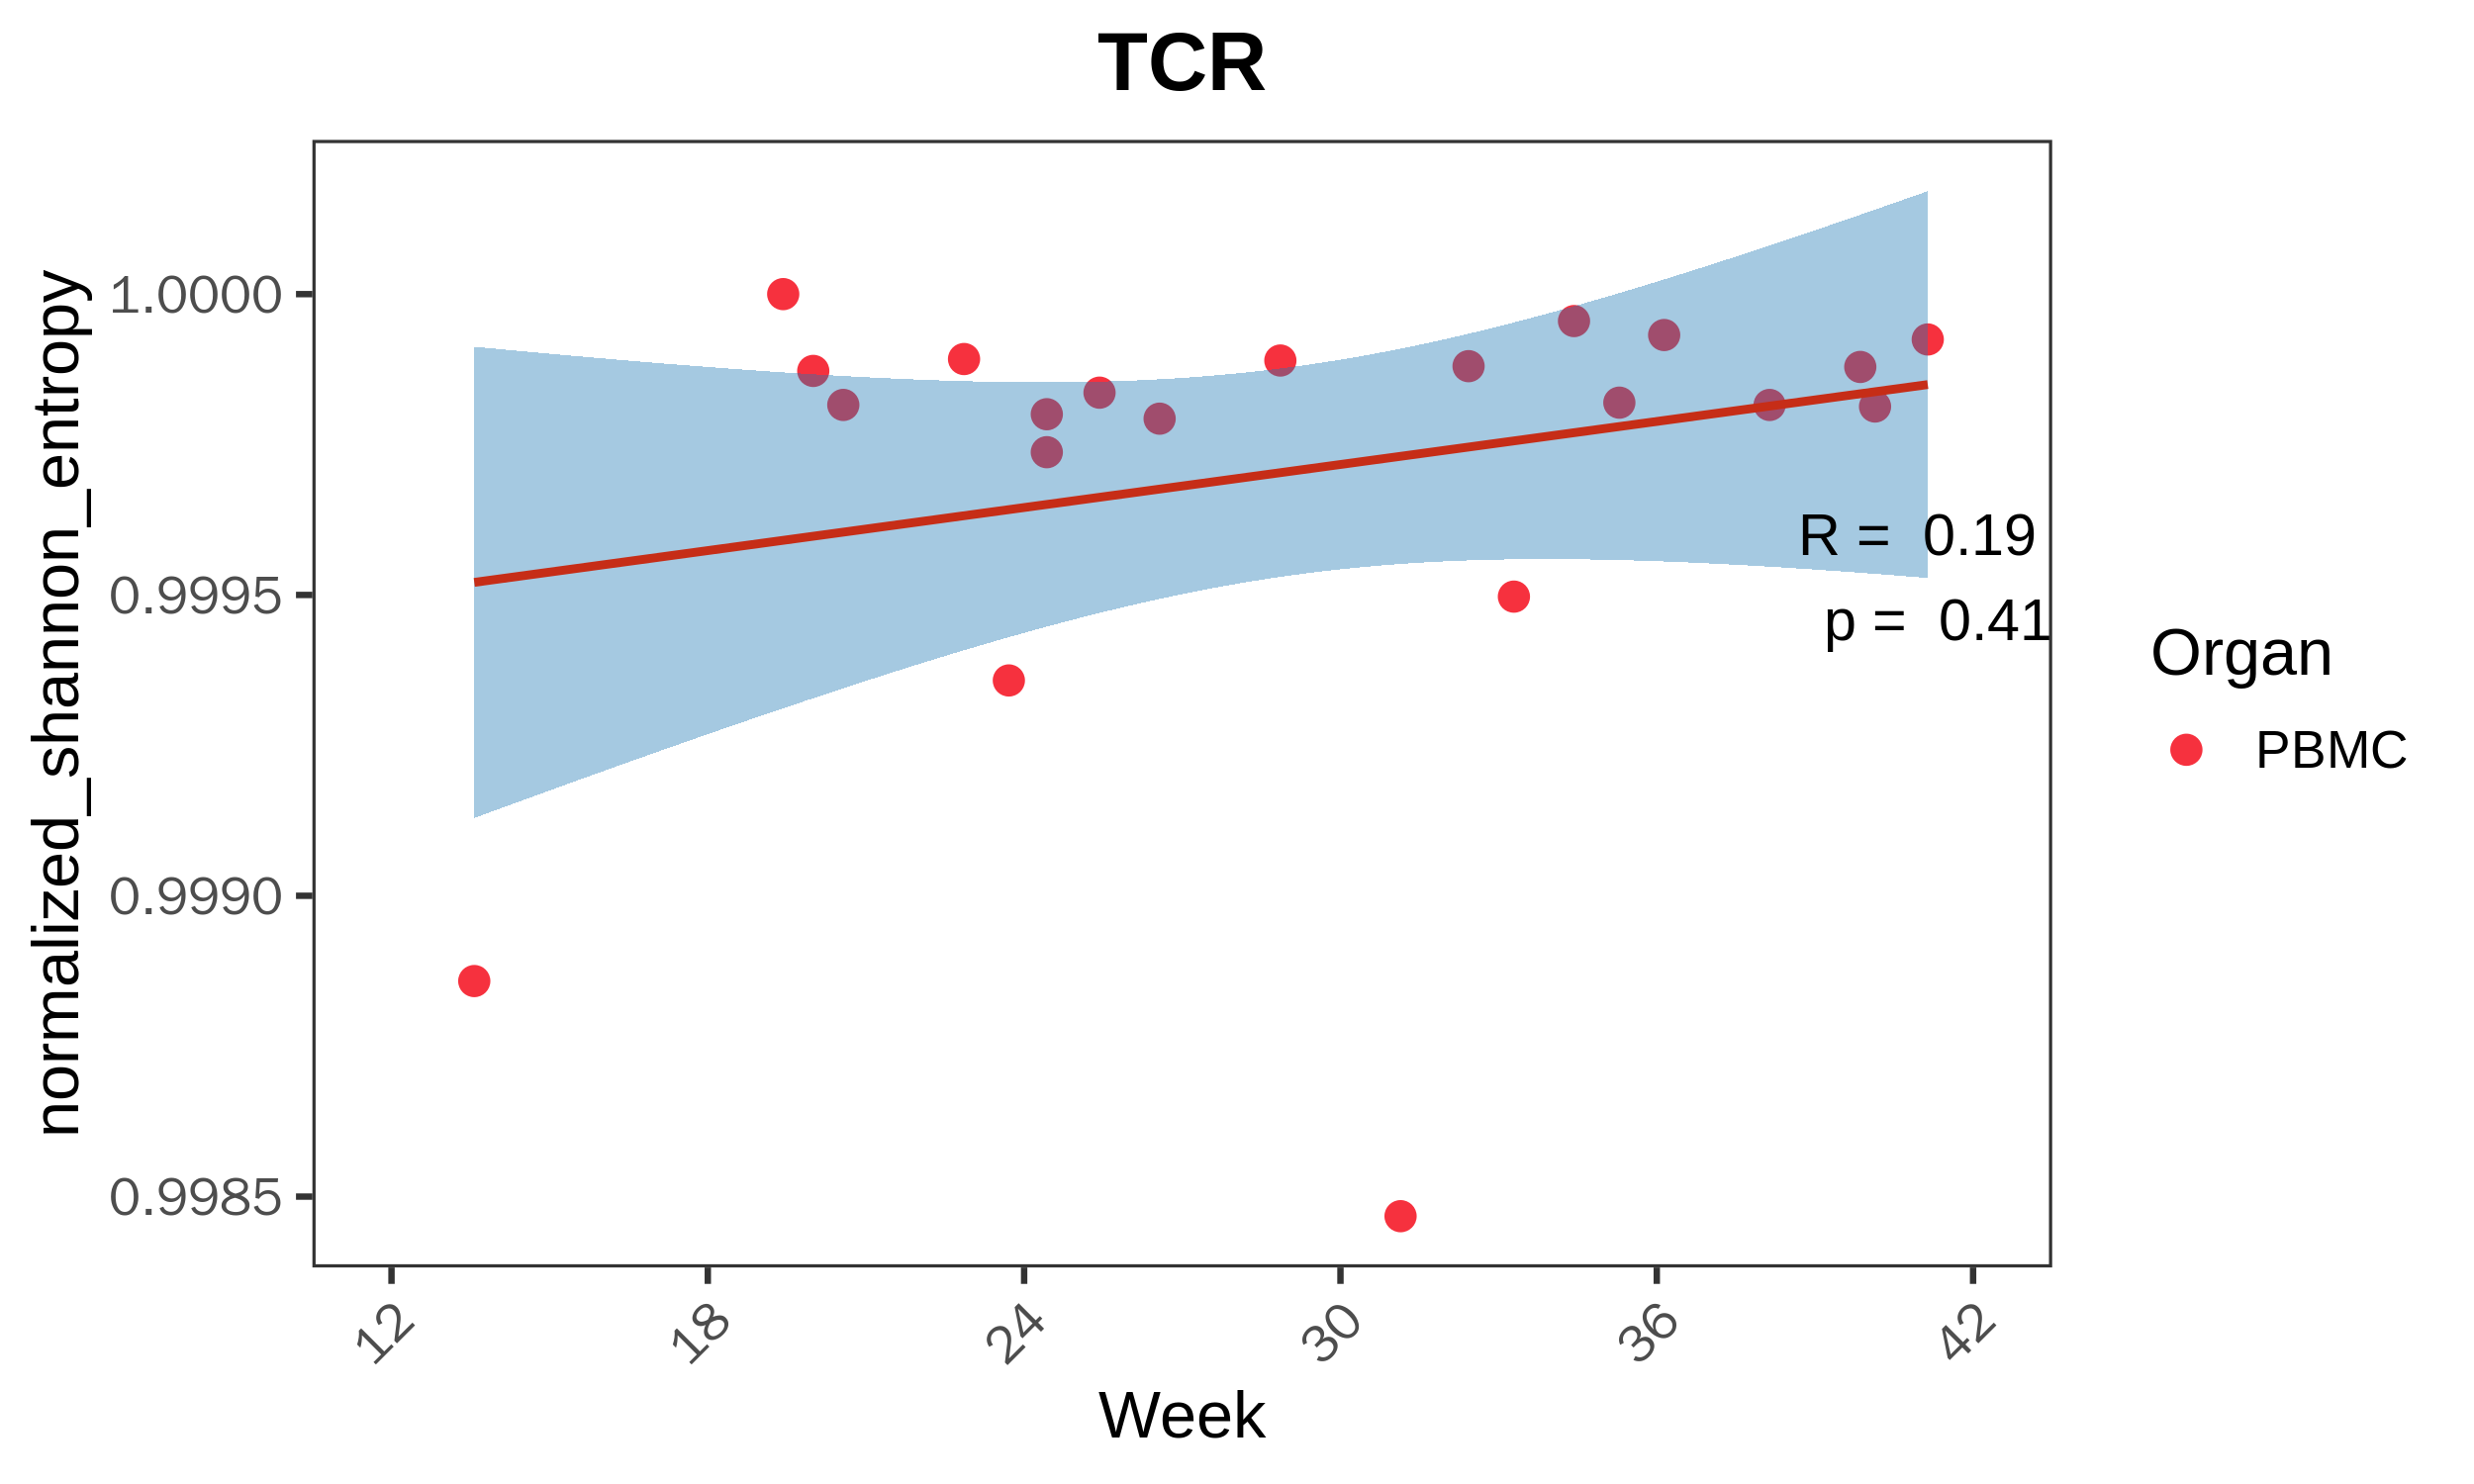

In [17]:
%%R -w 2500 -h 1500 -r 300 -i unique_data
library(dplyr)
library(ggplot2)
library(purrr)
library(tidyr)
unique_data <-subset(unique_data ,New_Body=="PBMC")
# unique_data<- unique_data %>% mutate(normalized_shannon_entropy_clone_id = 1 / simpson_clone_id)
correlation_results2 <- unique_data %>% 
    summarize(correlation = cor.test(as.numeric(Week), as.numeric(normalized_shannon_entropy_clone_id), method = "spearman")$estimate,
              p.value = cor.test(as.numeric(Week), as.numeric(normalized_shannon_entropy_clone_id), method = "spearman")$p.value)


library(scales)  # 确保你已经加载了 scales 包

p <- ggplot(unique_data) + 
    geom_point(aes(Week, as.numeric(normalized_shannon_entropy_clone_id), color = New_Body), size = 3) +
    geom_smooth(aes(as.numeric(Week),as.numeric(normalized_shannon_entropy_clone_id)), se = TRUE, show.legend = FALSE, fill = "#1F78B4", method = 'lm',
                color = "#c62d17", linetype = "solid") +
    theme_bw(base_size = 16) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          strip.background = element_blank()) + ylab(paste( "normalized_shannon_entropy")) + 
    scale_color_manual(values = c("#F6313E", "#fb862b", "#0eb0c8", "#6a73cf")) +
    ggtitle("TCR") + 
    theme(plot.title = element_text(hjust = 0.5, size = 20, face = "bold")) +labs(color="Organ")+
#     scale_y_log10()
scale_x_continuous(limits = c(12, 42), breaks = seq(12,44, by = 6)) 
p + geom_text(data = correlation_results2, aes(x = Inf, y = Inf, 
                                                label = paste("R = ", round(correlation, 2), 
                                                              "\n", "p = ", 
                                                              format.pval(p.value, digits = 2, eps = .001))), 
                vjust = 4, hjust = 1, size = 5, inherit.aes = FALSE)


# plot_with_correlation(TCRdiversity2, "Inv.Simpson")

# plot_with_correlation(TCRdiversity2, "Inv.Simpson")

`geom_smooth()` using formula = 'y ~ x'


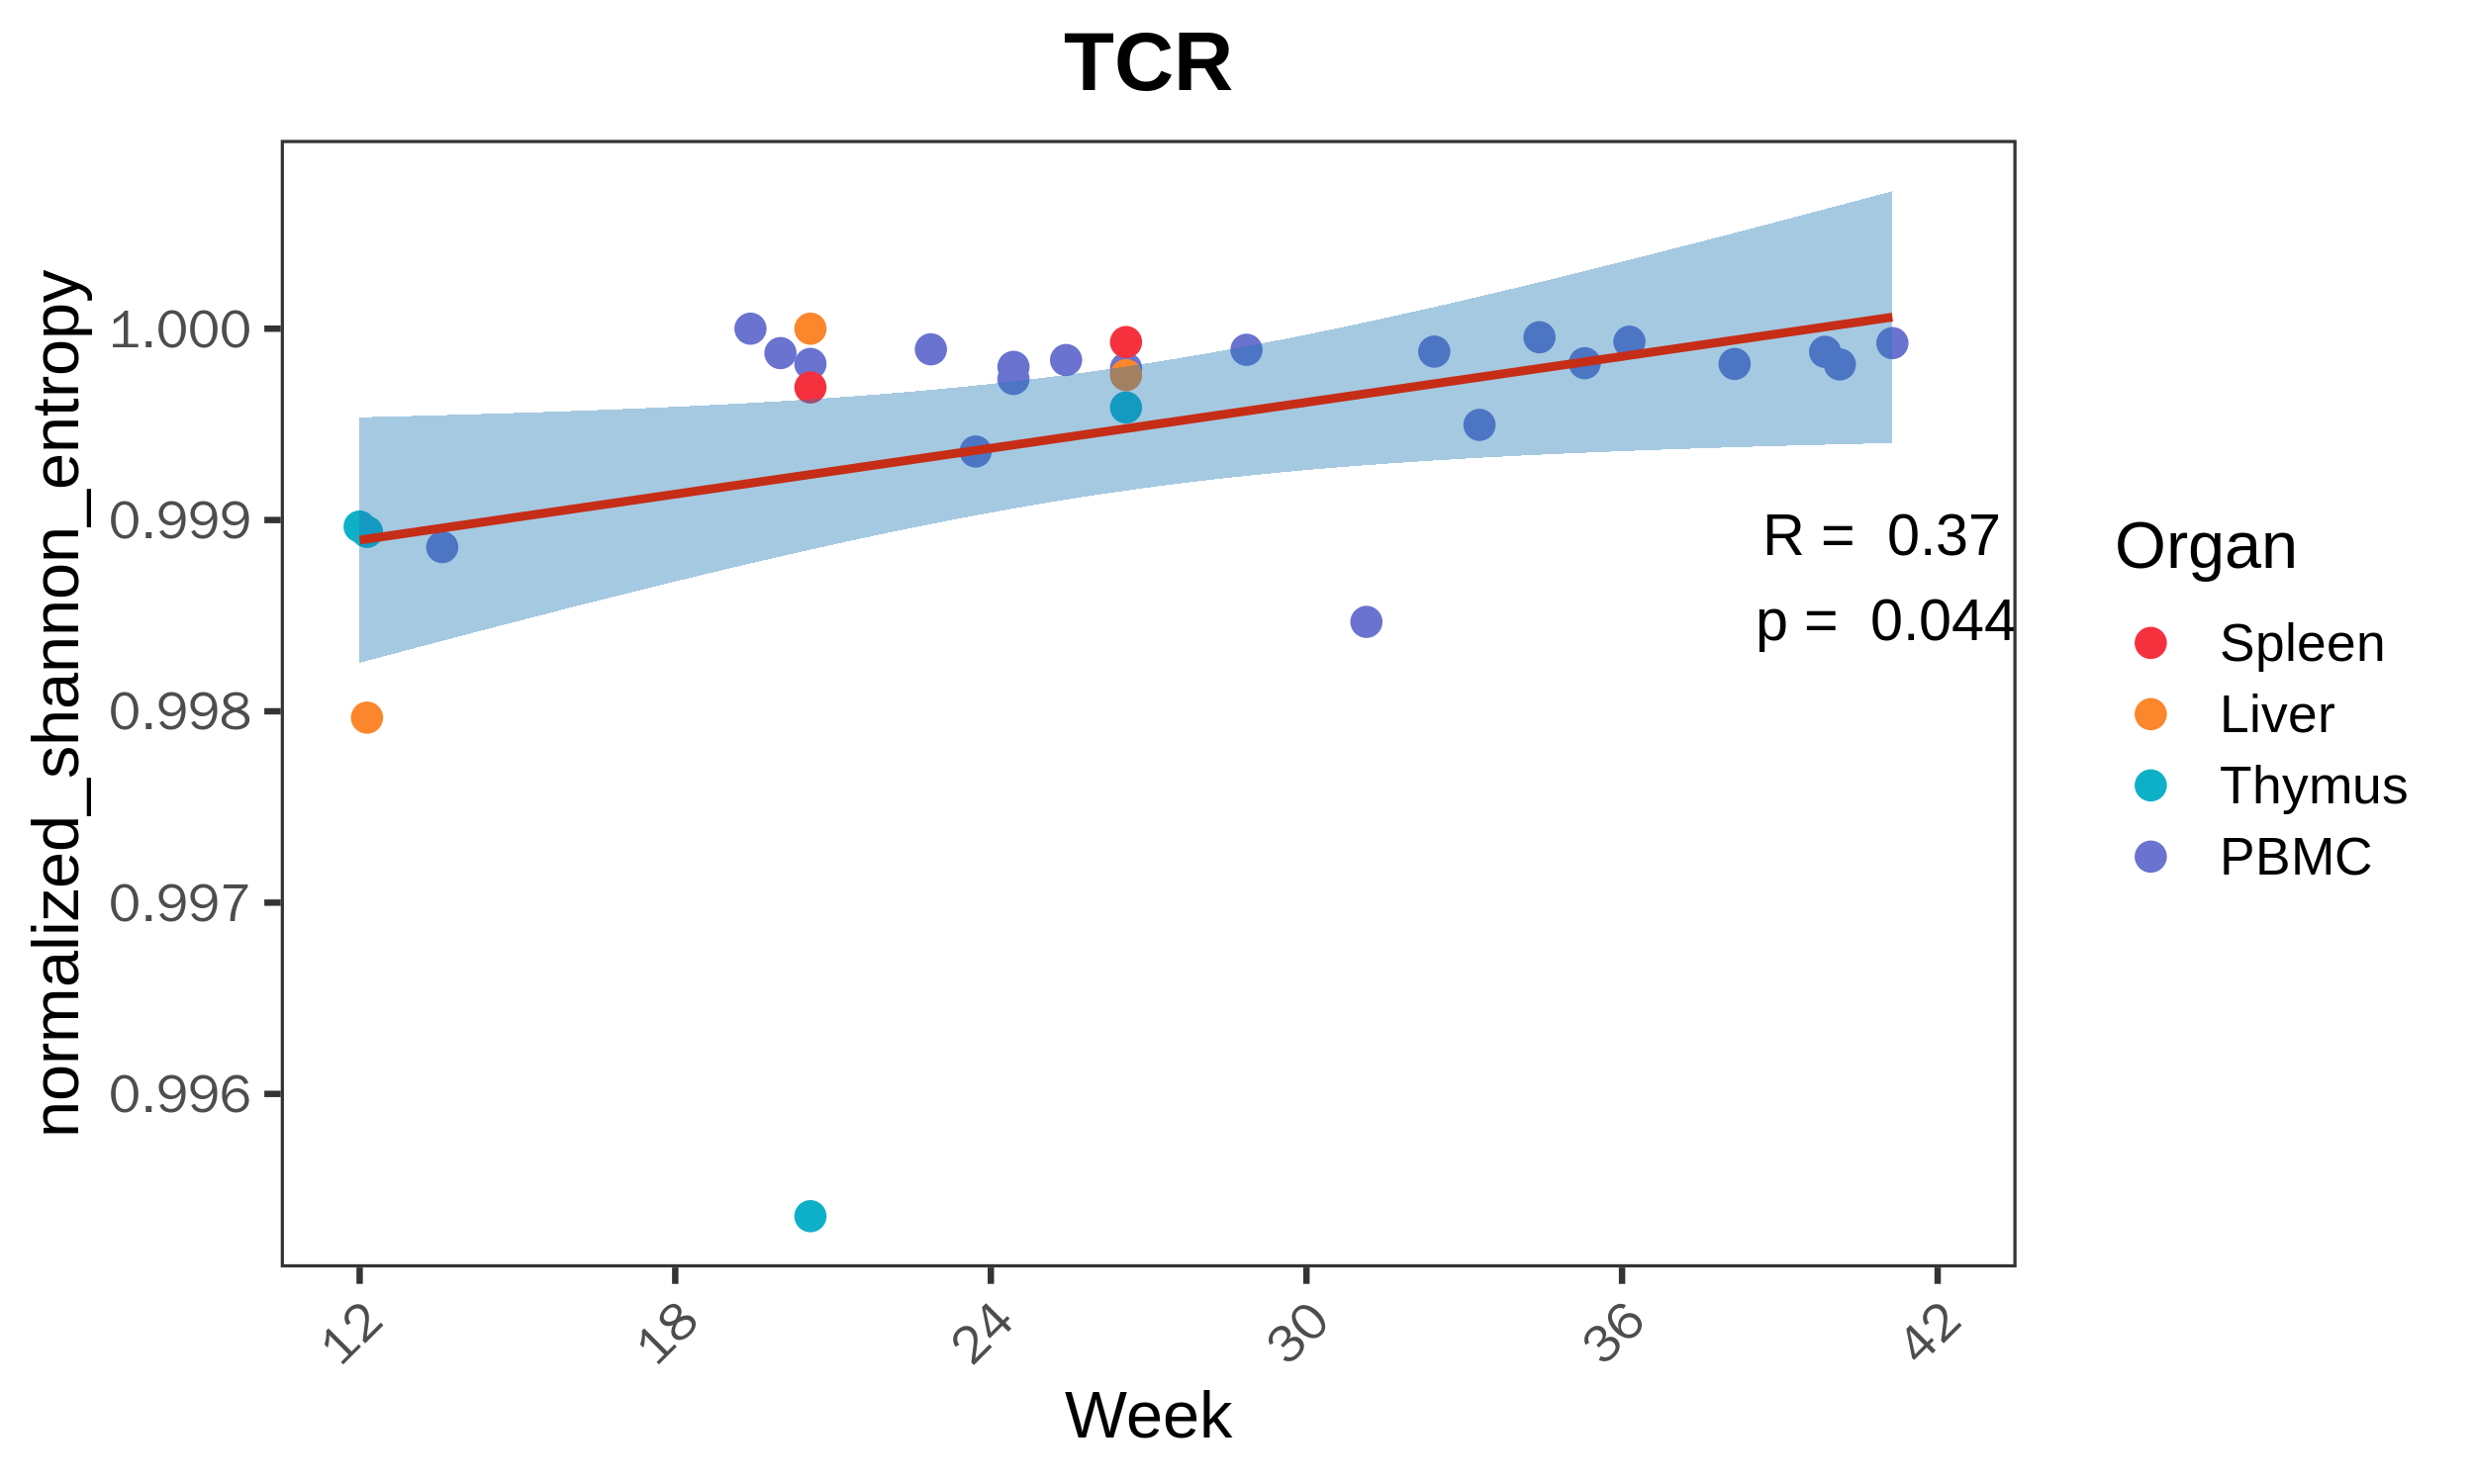

In [18]:
%%R -w 2500 -h 1500 -r 300 -i unique_data
library(dplyr)
library(ggplot2)
library(purrr)
library(tidyr)

# unique_data<- unique_data %>% mutate(normalized_shannon_entropy_clone_id = 1 / simpson_clone_id)
correlation_results2 <- unique_data %>% 
    summarize(correlation = cor.test(as.numeric(Week), as.numeric(normalized_shannon_entropy_clone_id), method = "spearman")$estimate,
              p.value = cor.test(as.numeric(Week), as.numeric(normalized_shannon_entropy_clone_id), method = "spearman")$p.value)


library(scales)  # 确保你已经加载了 scales 包

p <- ggplot(unique_data) + 
    geom_point(aes(Week, as.numeric(normalized_shannon_entropy_clone_id), color = New_Body), size = 3) +
    geom_smooth(aes(as.numeric(Week),as.numeric(normalized_shannon_entropy_clone_id)), se = TRUE, show.legend = FALSE, fill = "#1F78B4", method = 'lm',
                color = "#c62d17", linetype = "solid") +
    theme_bw(base_size = 16) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          strip.background = element_blank()) + ylab(paste( "normalized_shannon_entropy")) + 
    scale_color_manual(values = c("#F6313E", "#fb862b", "#0eb0c8", "#6a73cf")) +
    ggtitle("TCR") + 
    theme(plot.title = element_text(hjust = 0.5, size = 20, face = "bold")) +labs(color="Organ")+
scale_x_continuous(limits = c(12, 42), breaks = seq(12,44, by = 6)) 
p + geom_text(data = correlation_results2, aes(x = Inf, y = Inf, 
                                                label = paste("R = ", round(correlation, 2), 
                                                              "\n", "p = ", 
                                                              format.pval(p.value, digits = 2, eps = .001))), 
                vjust = 4, hjust = 1, size = 5, inherit.aes = FALSE)


# plot_with_correlation(TCRdiversity2, "Inv.Simpson")

# plot_with_correlation(TCRdiversity2, "Inv.Simpson")

`geom_smooth()` using formula = 'y ~ x'


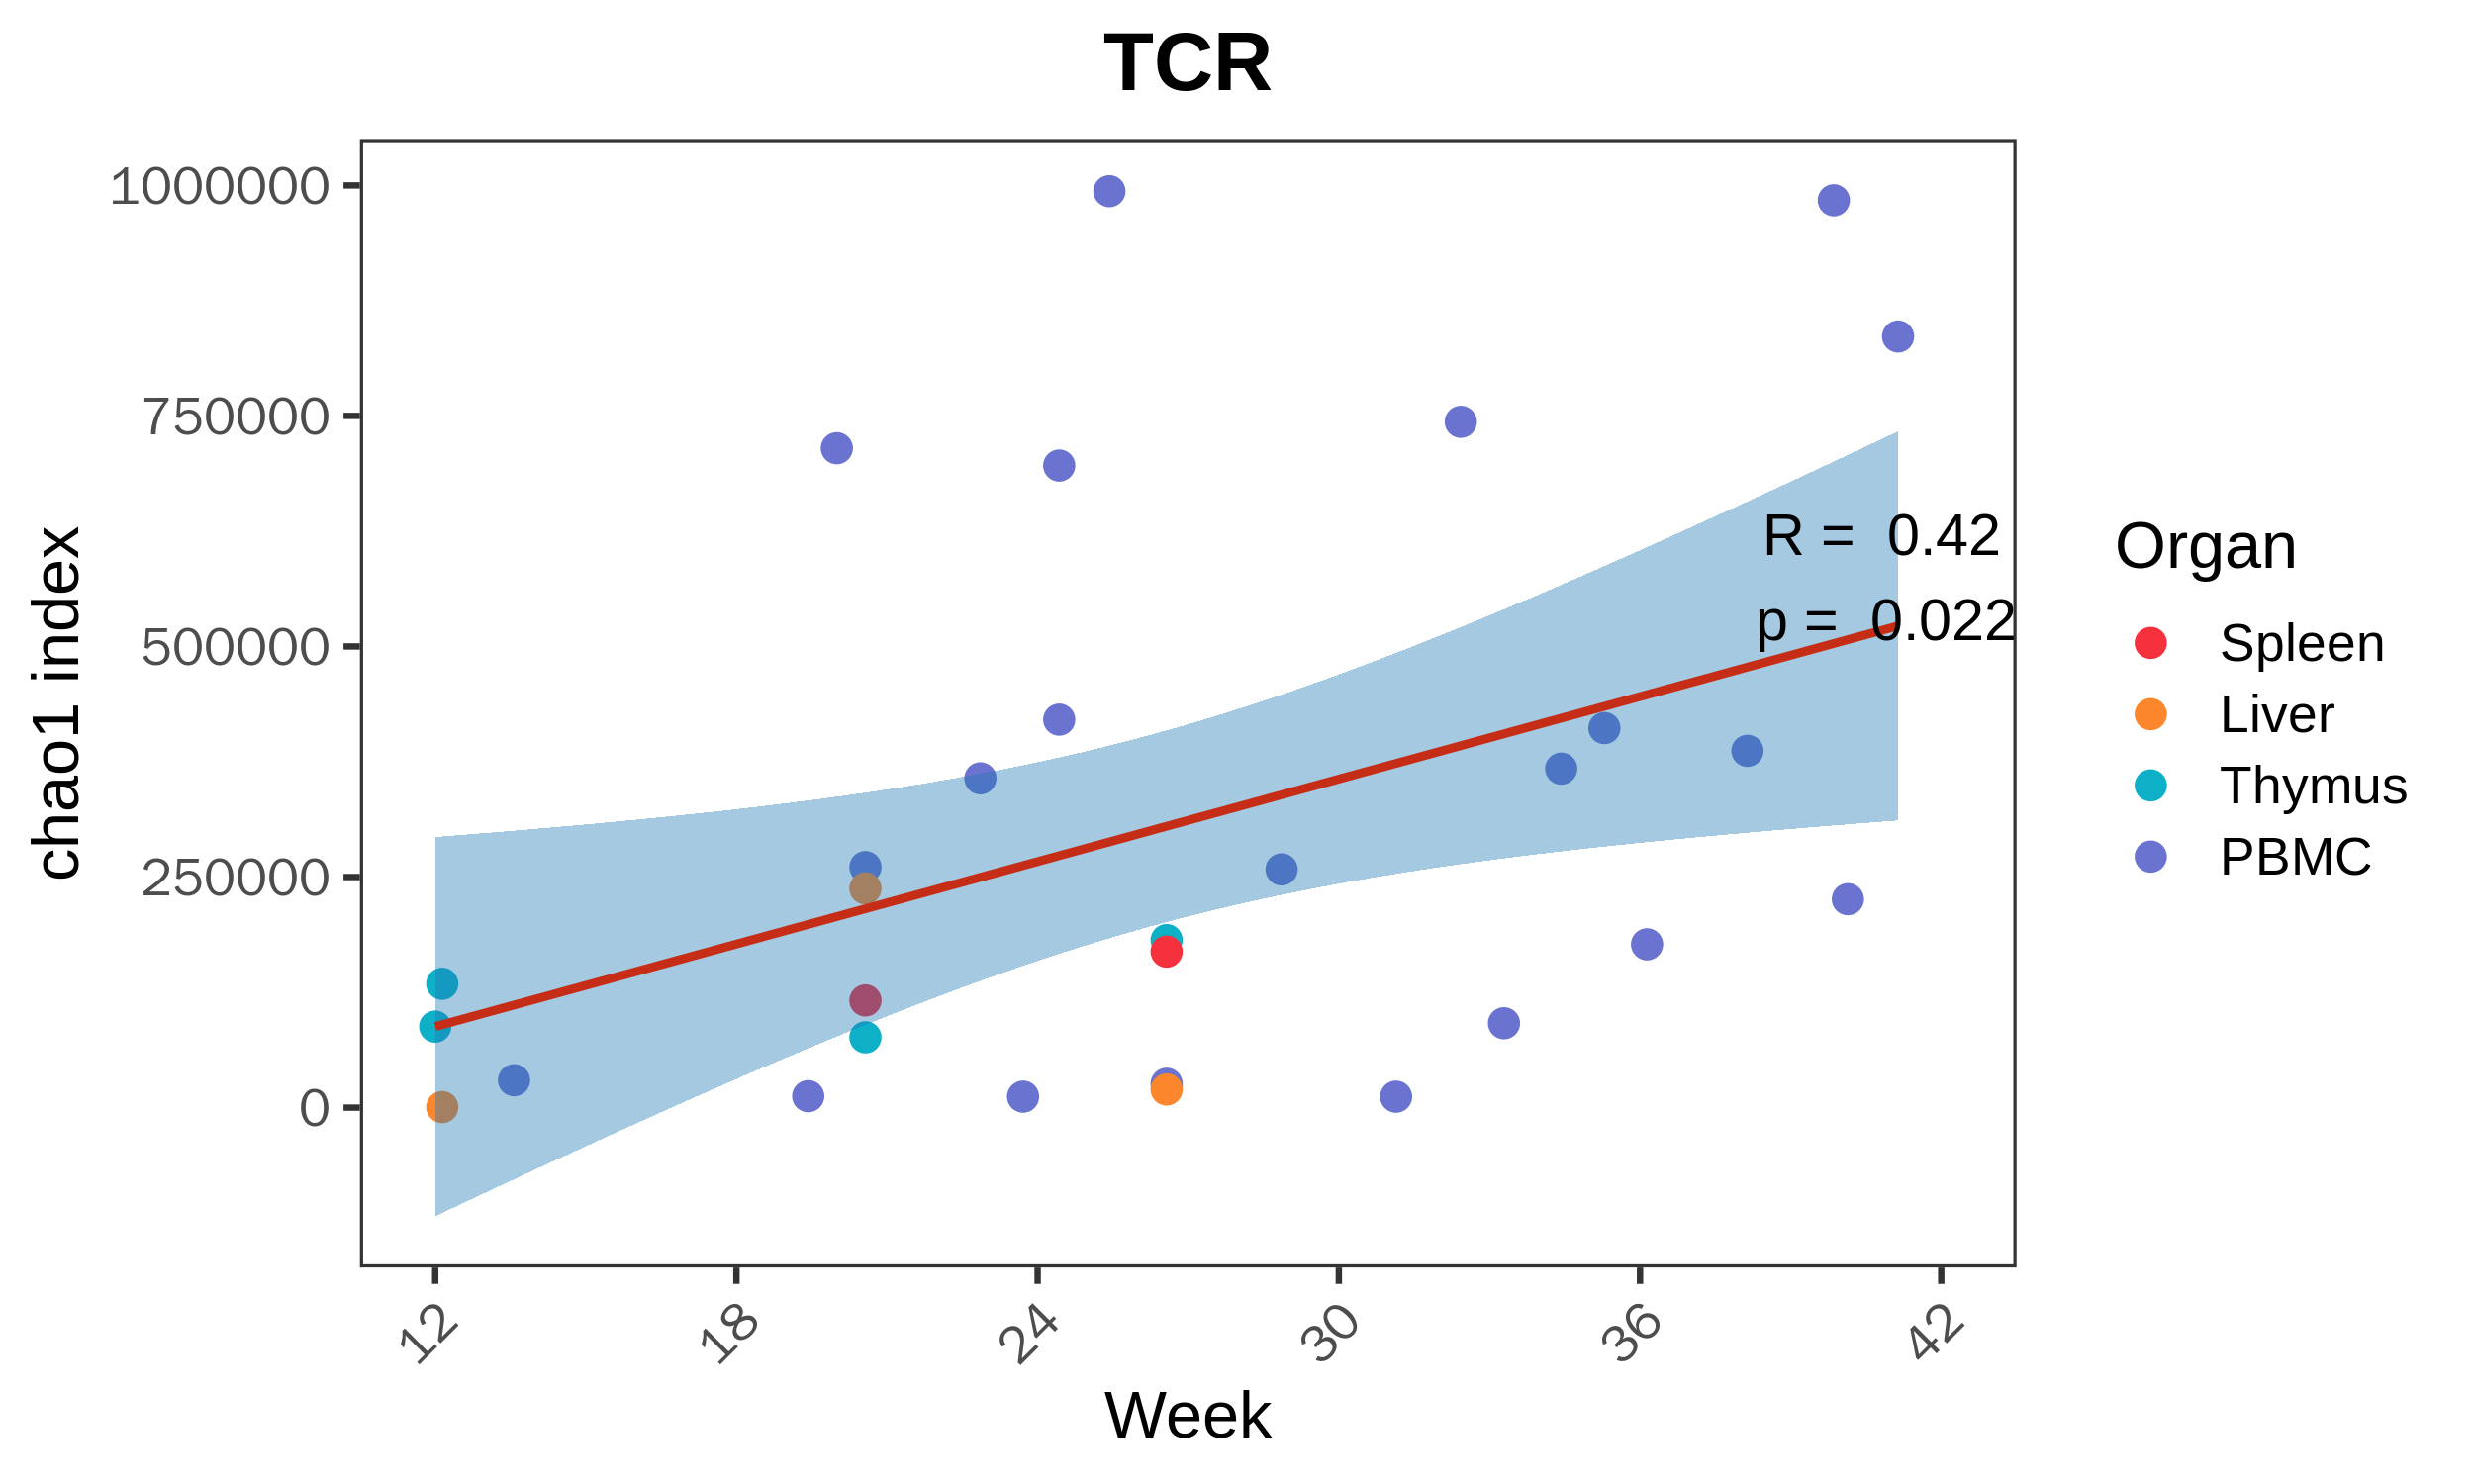

In [19]:
%%R -w 2500 -h 1500 -r 300 -i unique_data
library(dplyr)
library(ggplot2)
library(purrr)
library(tidyr)

# unique_data<- unique_data %>% mutate(chao1_clone_id = 1 / simpson_clone_id)
correlation_results2 <- unique_data %>% 
    summarize(correlation = cor.test(as.numeric(Week), as.numeric(chao1_clone_id), method = "spearman")$estimate,
              p.value = cor.test(as.numeric(Week), as.numeric(chao1_clone_id), method = "spearman")$p.value)


p <- ggplot(unique_data) + 
    geom_point(aes(Week, as.numeric(chao1_clone_id), color = New_Body), size = 3) +
    geom_smooth(aes(as.numeric(Week),as.numeric(chao1_clone_id)), 
                se = TRUE, show.legend = FALSE, fill = "#1F78B4", method = 'lm',
                color = "#c62d17", linetype = "solid") +
    theme_bw(base_size = 16) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          strip.background = element_blank()) + ylab(paste( "chao1 index")) + 
    scale_color_manual(values = c("#F6313E", "#fb862b", "#0eb0c8", "#6a73cf")) +
    ggtitle("TCR") + 
    theme(plot.title = element_text(hjust = 0.5, size = 20, face = "bold"))+
# scale_y_continuous(limits = c(0.99, 1), breaks = seq(0.99, 1.2, by = 0.001)) 
scale_x_continuous(limits = c(12, 42), breaks = seq(12,44, by = 6)) +labs(color="Organ")
  p + geom_text(data = correlation_results2, aes(x = Inf, y = Inf, 
                                                label = paste("R = ", round(correlation, 2), 
                                                              "\n", "p = ", 
                                                              format.pval(p.value, digits = 2, eps = .001))), 
                vjust = 4, hjust = 1, size = 5, inherit.aes = FALSE)


# plot_with_correlation(TCRdiversity2, "Inv.Simpson")

`geom_smooth()` using formula = 'y ~ x'


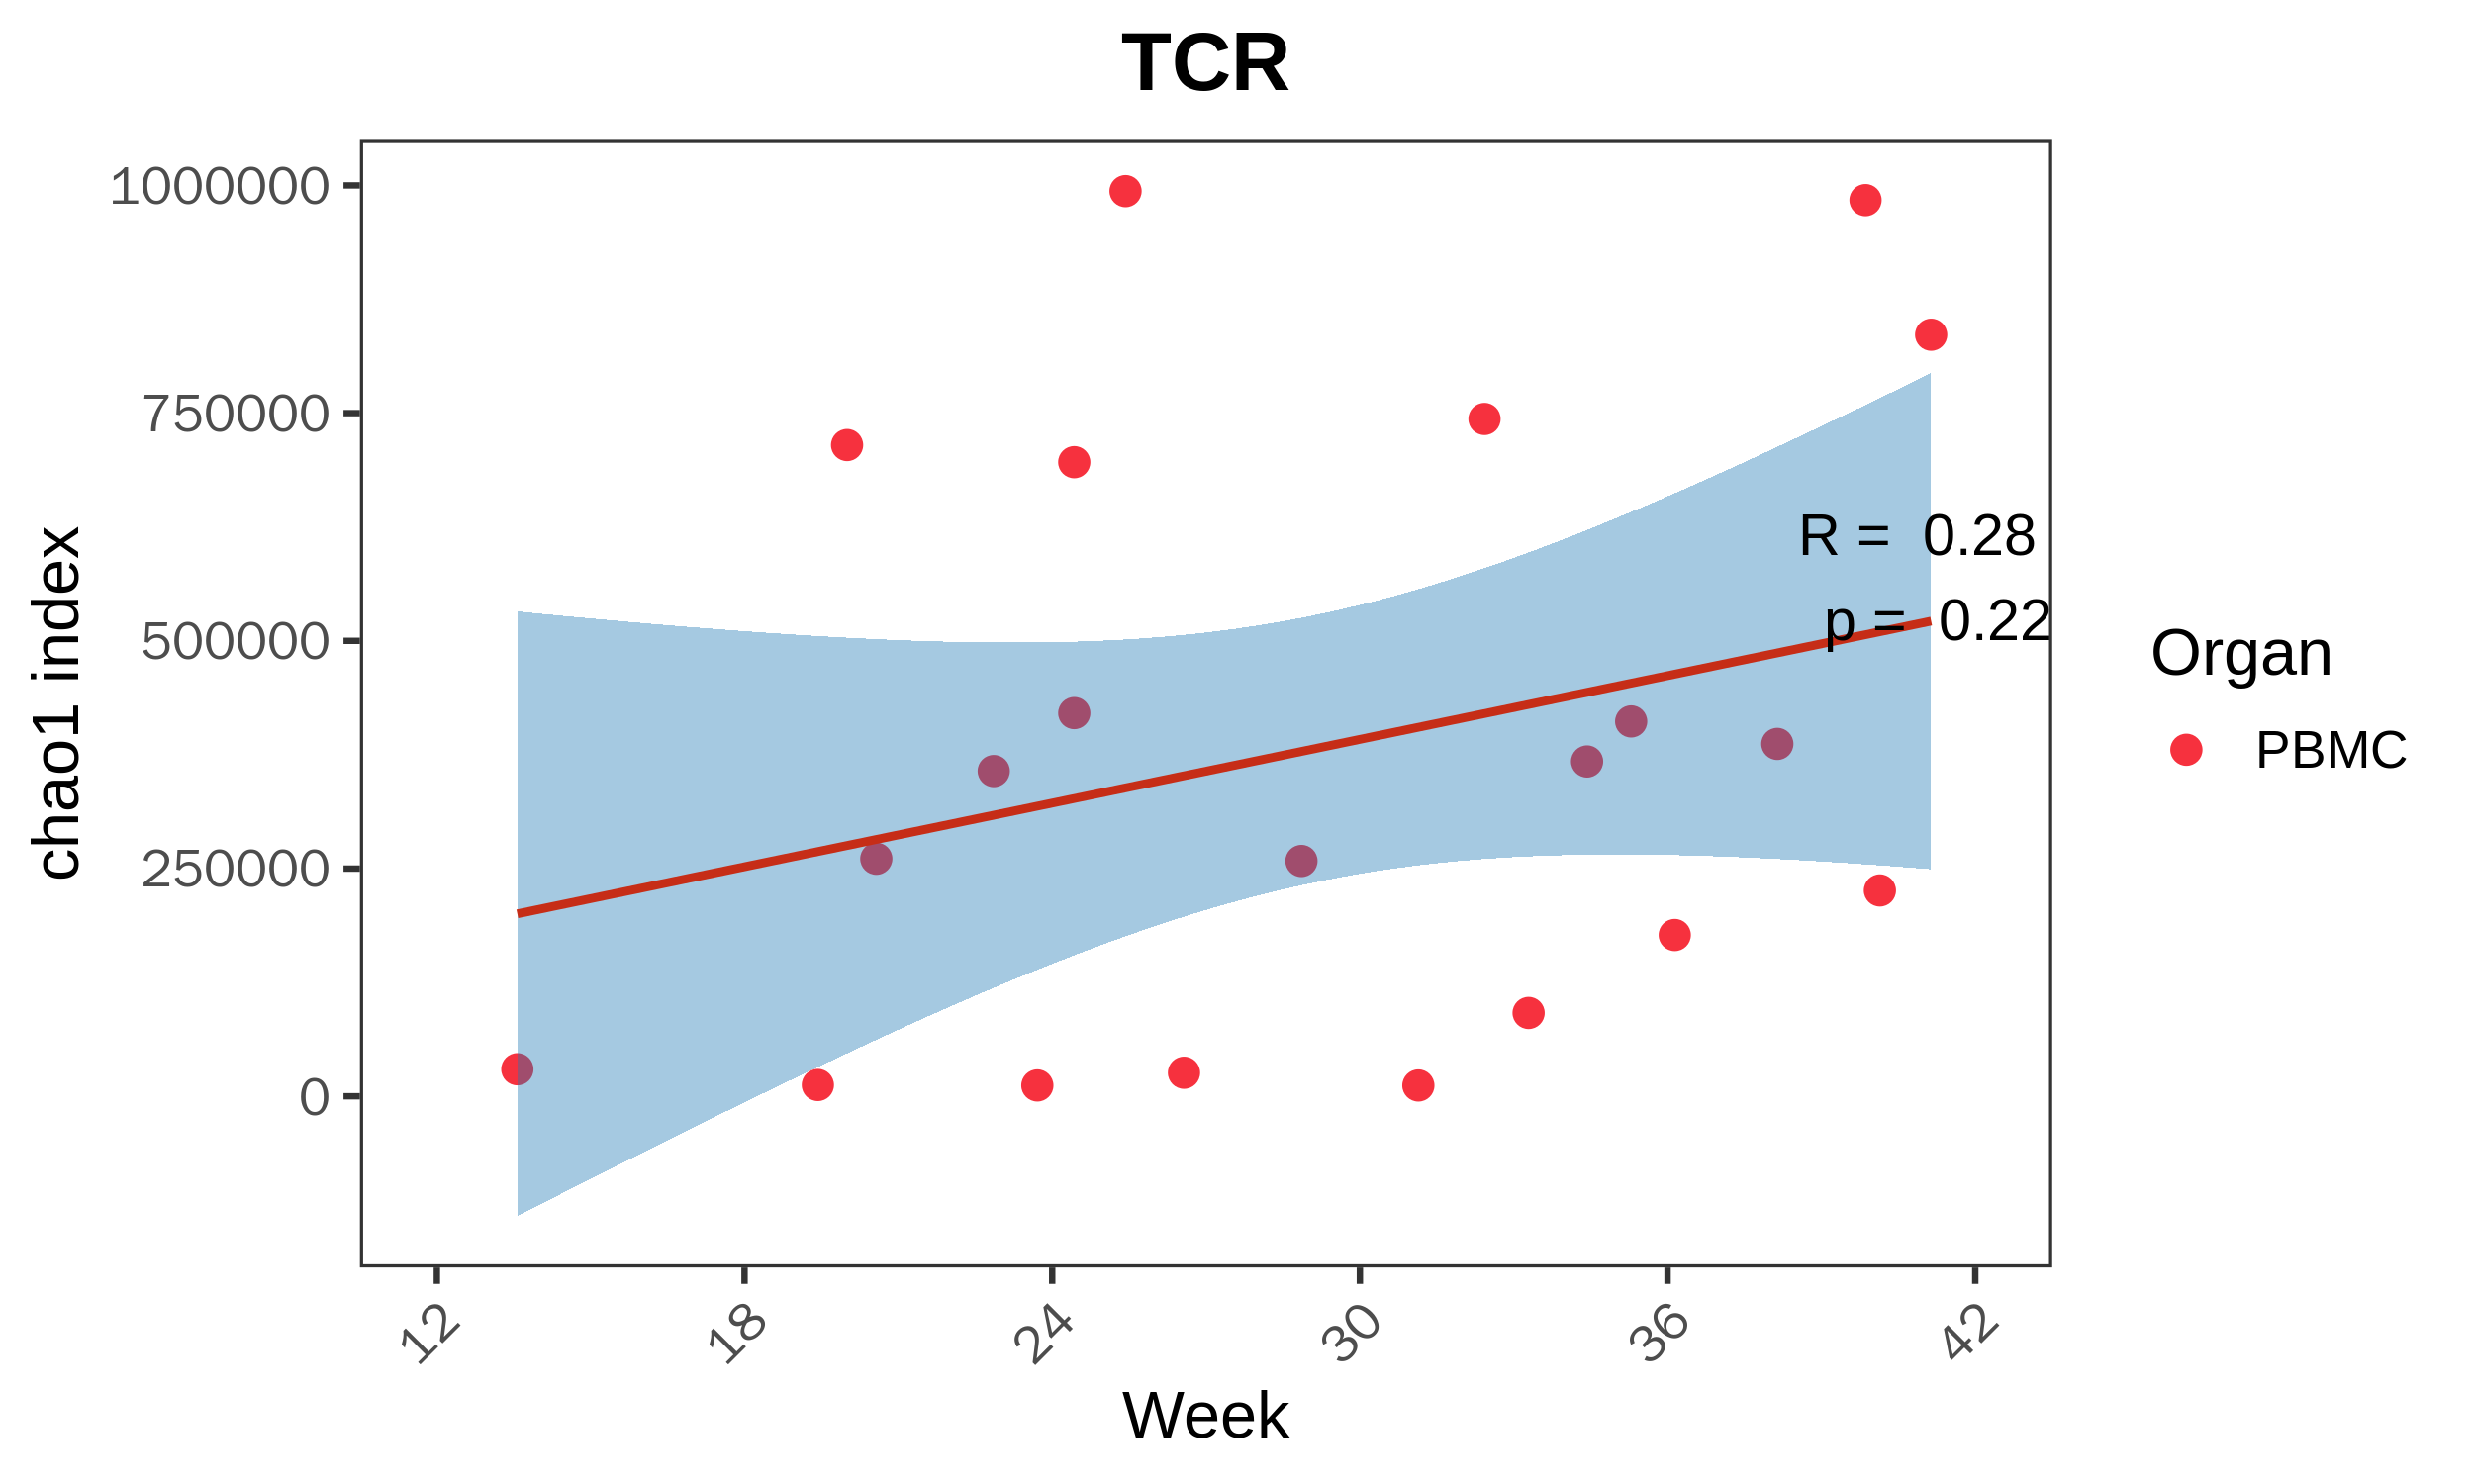

In [20]:
%%R -w 2500 -h 1500 -r 300 -i unique_data
library(dplyr)
library(ggplot2)
library(purrr)
library(tidyr)
unique_data=subset(unique_data,New_Body=="PBMC")
# unique_data<- unique_data %>% mutate(chao1_clone_id = 1 / simpson_clone_id)
correlation_results2 <- unique_data %>% 
    summarize(correlation = cor.test(as.numeric(Week), as.numeric(chao1_clone_id), method = "spearman")$estimate,
              p.value = cor.test(as.numeric(Week), as.numeric(chao1_clone_id), method = "spearman")$p.value)


p <- ggplot(unique_data) + 
    geom_point(aes(Week, as.numeric(chao1_clone_id), color = New_Body), size = 3) +
    geom_smooth(aes(as.numeric(Week),as.numeric(chao1_clone_id)), 
                se = TRUE, show.legend = FALSE, fill = "#1F78B4", method = 'lm',
                color = "#c62d17", linetype = "solid") +
    theme_bw(base_size = 16) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          strip.background = element_blank()) + ylab(paste( "chao1 index")) + 
    scale_color_manual(values = c("#F6313E", "#fb862b", "#0eb0c8", "#6a73cf")) +
    ggtitle("TCR") + 
    theme(plot.title = element_text(hjust = 0.5, size = 20, face = "bold"))+labs(color="Organ")+
# scale_y_continuous(limits = c(0.99, 1), breaks = seq(0.99, 1.2, by = 0.001)) 
scale_x_continuous(limits = c(12, 42), breaks = seq(12,44, by = 6)) 
  p + geom_text(data = correlation_results2, aes(x = Inf, y = Inf, 
                                                label = paste("R = ", round(correlation, 2), 
                                                              "\n", "p = ", 
                                                              format.pval(p.value, digits = 2, eps = .001))), 
                vjust = 4, hjust = 1, size = 5, inherit.aes = FALSE)


# plot_with_correlation(TCRdiversity2, "Inv.Simpson")